In [25]:
import itertools
from scipy import linalg
import matplotlib as mpl
import pandapower as pp
import pandapower.networks as pn
from pandapower.estimation import estimate
import random as rand
import pandas as pd
from sklearn import mixture
import numpy as np
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime
sns.set()

In [22]:
n_of_network_samples = 100
n_of_gaussians = 5
train_frac = 0.8

## Fitting Solar and Normal data separately with Gaussian Mixture
#### Initially, a GMM with 3 components will be fitted, like in the original paper. Later, other pdfs will be tested.

In [5]:
base_path = "/home/rafael/Downloads/electricity_data/"

train_data_path = base_path + "2011-2012 Solar home electricity data v2.csv"
test_data_path = base_path + "2012-2013 Solar home electricity data v2.csv"

In [6]:
train_data = pd.read_csv(train_data_path, skiprows=1)
test_data = pd.read_csv(test_data_path, skiprows=1)

### GC = General Consumption for electricity supplied all the time (primary tariff, either inclining block or time of use rates), excluding solar generation and controlled load supply 
### CL = Controlled Load Consumption (Off peak 1 or 2 tariffs)
### GG = Gross Generation for electricity generated by the solar system with a gross metering configuration, measured separately to household loads

In [7]:
train_data.head()

,Customer,Generator Capacity,Postcode,Consumption Category,date,0:30,1:00,1:30,2:00,2:30,...,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30,0:00,Row Quality
0,1,3.78,2076,CL,1/07/2011,1.250,1.250,1.250,0.625,0.219,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.063,NaN
1,1,3.78,2076,GC,1/07/2011,1.077,0.669,0.674,0.615,0.321,...,0.276,0.241,0.168,0.234,0.164,0.639,0.118,0.219,0.162,NaN
2,1,3.78,2076,GG,1/07/2011,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN
3,1,3.78,2076,CL,2/07/2011,1.238,1.244,1.194,0.000,0.888,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.075,NaN
4,1,3.78,2076,GC,2/07/2011,0.476,0.130,0.044,0.094,0.032,...,0.234,0.306,0.183,0.240,0.170,0.506,0.224,0.088,0.084,NaN


In [8]:
def extract_consumption_values(data_df):
    
    selected_columns = [col for col in data_df.columns if ":" in col]

    data_df_general = data_df[data_df['Consumption Category'] == 'GC']
    
    data_df_solar = data_df[data_df['Consumption Category'] == 'GG']
    
    return data_df_general[selected_columns], data_df_solar[selected_columns]


In [9]:
train_data_general, train_data_solar = extract_consumption_values(train_data)
test_data_general, test_data_solar = extract_consumption_values(test_data)

In [10]:
train_values = np.reshape(train_data_general.values, (train_data_general.shape[0]*train_data_general.shape[1],1))
test_values = np.reshape(test_data_general.values, (test_data_general.shape[0]*test_data_general.shape[1],1))

In [ ]:
# Fit a Dirichlet process Gaussian mixture using five components
dpgmm = mixture.BayesianGaussianMixture(n_components=n_of_gaussians,
                                        covariance_type='full').fit(train_values)
# plot_results(train_values, dpgmm.predict(train_values), dpgmm.means_, dpgmm.covariances_, 1,
#              'Bayesian Gaussian Mixture with a Dirichlet process prior (train)')
plt.scatter(dpgmm.predict(test_values),test_values)

In [ ]:
# plot_results(test_values, dpgmm.predict(test_values), dpgmm.means_, dpgmm.covariances_, 1,
#              'Bayesian Gaussian Mixture with a Dirichlet process prior (test)')
plt.scatter(gmm.predict(test_values),test_values)

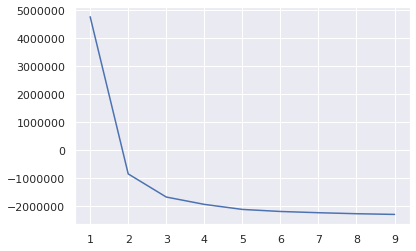

In [103]:
#Code based on: https://stackoverflow.com/questions/39920862/model-selection-for-gaussianmixture-by-using-gridsearch 
bic = np.zeros(9)
n = np.arange(1,10)
models = []
#loop through each number of Gaussians and compute the BIC, and save the model
for i,j in enumerate(n):
    #create mixture model with j components
    gmm = mixture.GaussianMixture(n_components=j)
    #fit it to the data
    gmm.fit(train_values)
    #compute the BIC for this model
    bic[i] = gmm.bic(test_values)
    #add the best-fit model with j components to the list of models
    models.append(gmm)
    
plt.plot(n,bic)

#### n_of_components=5 was initially chosen

In [12]:
gmm = mixture.GaussianMixture(n_components=n_of_gaussians)
#fit it to the data
gmm.fit(train_values)

GaussianMixture(n_components=5)

#### Solar consumption data was either 0 or NaN. We will only fit GMM on the General Consumption values.

## Generating samples from Network

In [11]:
# Define Network
net = pn.case14()

In [21]:
injection_values, network_state_samples = np.zeros((n_of_network_samples,net.bus.shape[0])), np.zeros((n_of_network_samples,net.bus.shape[0]))

for i in range(n_of_network_samples):
    
    net = pn.case14()
    
    #print(2e-3*np.squeeze(gmm.sample(n_samples=net.bus.shape[0])[0]))
    
    injection_values_per_iter = 2e-3*np.squeeze(gmm.sample(n_samples=net.bus.shape[0])[0])
    
    injection_values[i,:] = injection_values_per_iter
    
    for j in range(net.bus.shape[0]):
        
        pp.create_sgen(net=net, bus=j, p_mw=injection_values_per_iter[j])
        
    pp.runpp(net)
    
    network_state_samples[i,:] = net.res_bus.vm_pu.values

## Fitting NN Model

In [54]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

model = tf.keras.models.Sequential([
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(2*injection_values.shape[1],input_dim=injection_values.shape[1]),
    #tf.keras.layers.Dense(2*injection_values.shape[1], input_dim=2*injection_values.shape[1]),
    tf.keras.layers.Dense(network_state_samples.shape[1], input_dim=2*injection_values.shape[1]),
])

model.compile(
    loss='mse', # keras.losses.mean_squared_error
    optimizer=tf.keras.optimizers.SGD(lr=0.2),
)

print("Training ... With default parameters, this takes less than 10 seconds.")
training_history = model.fit(
    injection_values[:int(injection_values.shape[0]*train_frac)], # input
    network_state_samples[:int(injection_values.shape[0]*train_frac)], # output
    batch_size=int(injection_values.shape[0]*train_frac),
    verbose=0, # Suppress chatty output; use Tensorboard instead
    epochs=35,
    validation_data=(injection_values[int(injection_values.shape[0]*train_frac):], network_state_samples[int(injection_values.shape[0]*train_frac):]),
    callbacks=[tensorboard_callback],
)

print("Average test loss: ", np.average(training_history.history['loss']))


Training ... With default parameters, this takes less than 10 seconds.
Average test loss:  0.12255971609016082


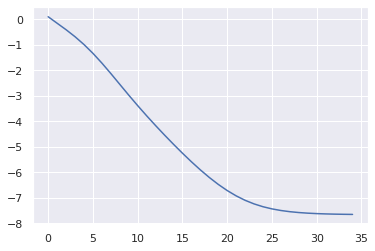

In [55]:
plt.plot(np.log(training_history.history['loss']))

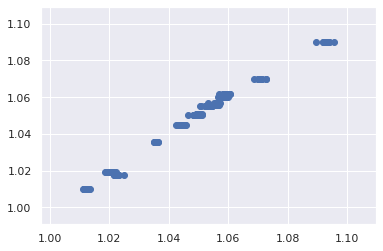

In [56]:
plt.scatter(model.predict(injection_values[-10:]),network_state_samples[-10:])

In [38]:
for i in range(net.bus.shape[0]):

    pp.create_measurement(net, "v", "bus", rand.random(), .004, i)

for i in range(net.bus.shape[0]-1):
    
    pp.create_measurement(net, "p", "bus", rand.random(), .004, i)


Attention! Signing system of P,Q measurement of buses now changed to load reference (match pandapower res_bus pq)!
Attention! Signing system of P,Q measurement of buses now changed to load reference (match pandapower res_bus pq)!
Attention! Signing system of P,Q measurement of buses now changed to load reference (match pandapower res_bus pq)!


In [39]:
success = estimate(net, init="flat")
V, delta = net.res_bus_est.vm_pu, net.res_bus_est.va_degree